In [1]:
import numpy as np
import datetime

import matplotlib.pyplot as plt

from scipy.optimize import minimize

import astropy.units as u
from astropy.wcs import WCS
from astropy.time import Time
from astropy.table import Table, join, vstack, hstack
from astropy.io import fits
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.coordinates import SkyCoord

from photutils import CircularAperture

from skycam_utils.astrometry import update_altaz, load_wcs
from skycam_utils.photometry import load_skycam_catalog, load_mask, match_stars
from skycam_utils.pipeline import process_stellacam_image
from skycam_utils.fit_wcs import wcs_zea, wcs_refine_zea
from skycam_utils.fisheye_map import Fisheye, distortion_mapper, distortion_mapper_looper

In [2]:
skycat = load_skycam_catalog()

In [3]:
hdul = fits.open("image_0003000.fits.gz")
im = hdul[0].data
hdr = hdul[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  640                                                  
NAXIS2  =                  480                                                  
EXTEND  =                    T                                                  
GAIN    =                  106                                                  
FRAME   = '256 Frames'                                                          
UT      = 'MON OCT 16 07:59:33 2017'                                            
LST     = '02:16:09.777'                                                        
AZ      =         179.28606672                                                  
EL      =          53.16977134                                                  
SCOPEX  =                  3

In [4]:
dt = datetime.datetime.strptime(hdr['UT'], "%a %b %d %H:%M:%S %Y")
tobs = Time(dt, scale='utc')
tobs

<Time object: scale='utc' format='datetime' value=2017-10-16 07:59:33>

In [5]:
skycat = update_altaz(skycat, time=tobs)

In [6]:
wcs_initial = load_wcs(year=2017)
wcs_refined = WCS("../2020/wcs_refined.fits")

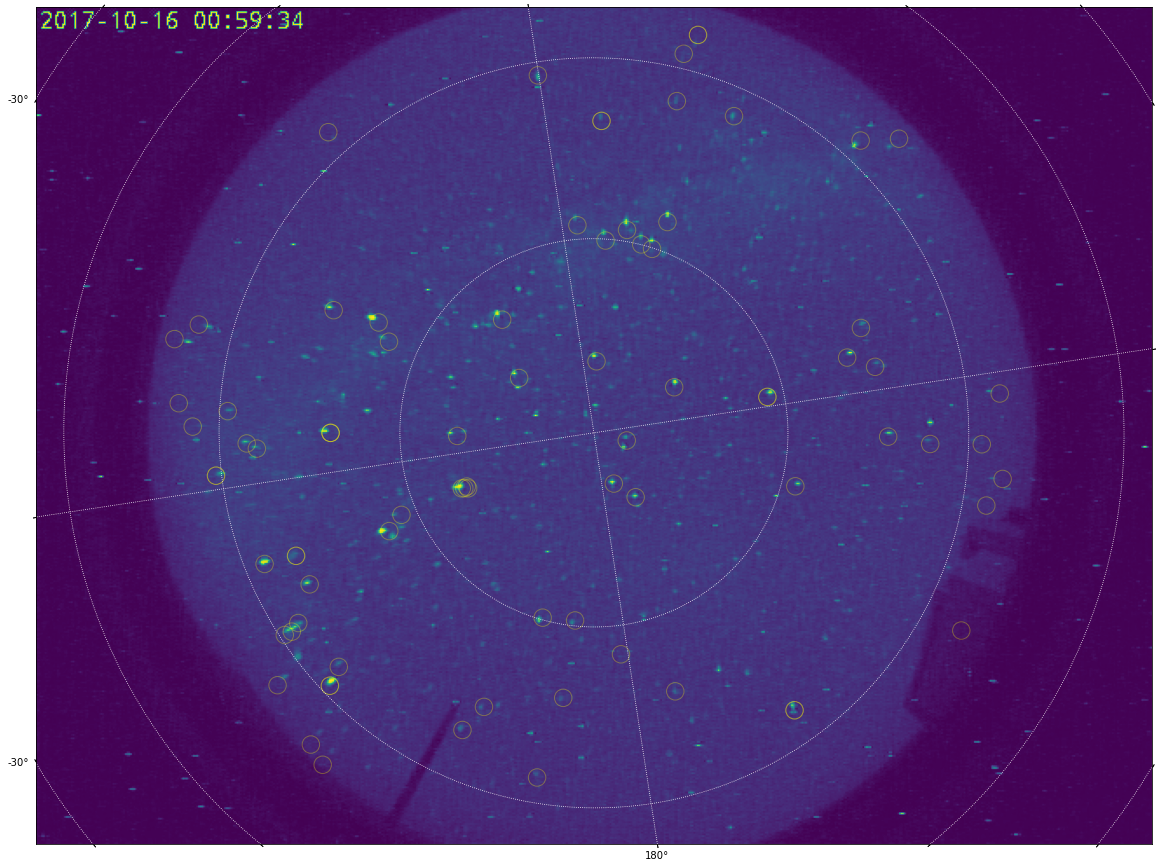

In [7]:
plt.figure(figsize=[20,20])
skycat = skycat[skycat['Alt'] > 20.0]
skycat = skycat[skycat['Magnitude'] < 4]
pred_x, pred_y = wcs_initial.all_world2pix(skycat['Az'], skycat['Alt'], 0)
pred_aps = CircularAperture((pred_x, pred_y), r=5.)
ax = plt.subplot(projection=wcs_initial)
ax.imshow(im, origin='lower')
ax.coords[0].set_format_unit(u.deg)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.grid(color='white', ls='dotted')
pred_aps.plot(color='yellow', lw=1., alpha=0.3)
plt.show()

In [8]:
mask = load_mask(year=2017)

In [14]:
bkg_image, diff_image, segm, sky_mag, catalog = process_stellacam_image("image_0003000.fits.gz", wcs=wcs_initial, mask=mask, write=True, zp=0)

In [15]:
matched = match_stars(skycat, catalog, wcs_initial, max_sep=1.5*u.deg)

In [16]:
matched

<QTable length=40>
  HD     Vmag    U-B   ... source_sum  background_mean        obs_mag      
                       ...                                                 
int64  float64 float64 ...   uint64        float64            float64      
------ ------- ------- ... ---------- ------------------ ------------------
  4614      --      -- ...       1049 50.022022382340666 -7.551938720483895
 29139      --      -- ...       4131 42.672352613084215 -9.040137987441465
203280    2.45    0.11 ...       1053 45.845015336309736 -7.556070927963717
   886      --      -- ...       1268  38.27783448376021 -7.757798133864284
 19356      --      -- ...       1899  45.58379187615056 -8.196312411842543
 12533     2.1    0.92 ...       1933  44.07054237290532 -8.215579635071382
 47105    1.92    0.05 ...       1552 45.340877166900896 -7.977229292305425
 37128      --      -- ...       5507 41.167901405728585 -9.352287691203205
 24398    2.85   -0.78 ...       1436 43.173197542477546 -7.892886099765704
   ...     ...     ... ...        ...                ...                ...
  8890      --      -- ...       1506  37.42861532987498 -7.944562429661705
 42995      --      -- ...        963  48.07006868289427 -7.459065717811336
 34085      --      -- ...       4377  37.00998019433018 -9.102941366532786
  8538      --      -- ...       1579  49.47787474049078 -7.995955325020736
217906      --      -- ...       1486  39.06434002045124 -7.930047023561391
  3712      --      -- ...       1675  49.53060096333429  -8.06003702843216
 11636    2.65     0.1 ...       1517  41.73378096350803 -7.952463951966826
   358      --      -- ...       2346  40.17258614675557 -8.425820019448777
 44478      --      -- ...       1311 47.277664910272215  -7.79400672922521
  5394      --      -- ...       2905  48.59831945597573 -8.657865341815874

In [19]:
dmag = matched['obs_mag'] - matched['Magnitude']
#matched = matched[dmag > -11]
dmag.mean(), dmag.std()

(-10.445506174046114, 0.612546358229993)

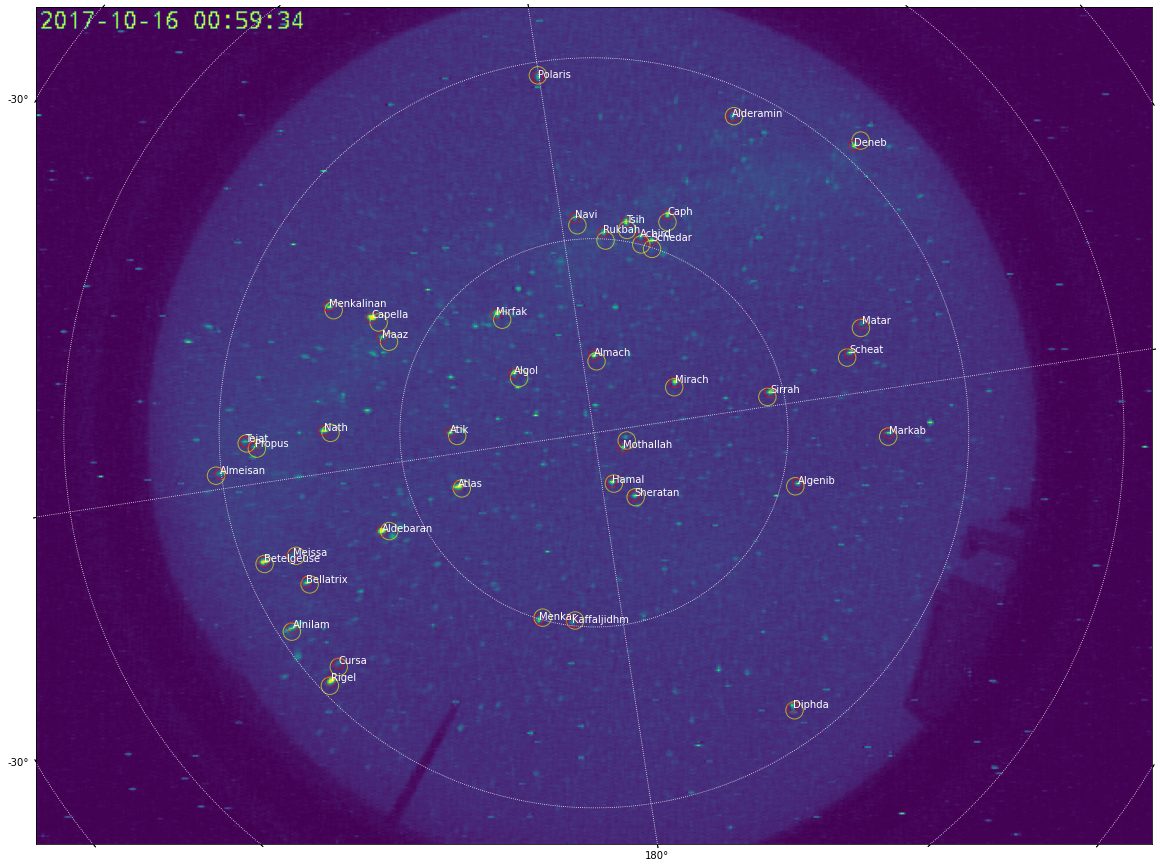

In [18]:
plt.figure(figsize=[20,20])
pred_x, pred_y = wcs_initial.all_world2pix(matched['Az'], matched['Alt'], 0)
pred_aps = CircularAperture((pred_x, pred_y), r=5.)
meas_aps = CircularAperture((matched['xcentroid'], matched['ycentroid']), r=3.)
ax = plt.subplot(projection=wcs_initial)
ax.imshow(im, origin='lower')
ax.coords[0].set_format_unit(u.deg)
ax.coords[0].set_auto_axislabel(False)
ax.coords[1].set_auto_axislabel(False)
ax.grid(color='white', ls='dotted')
pred_aps.plot(color='yellow', lw=1., alpha=0.6)
meas_aps.plot(color='red', lw=1, alpha=0.6)
for row in matched:
    ax.annotate(row['Star Name'], (row['xcentroid'].value, row['ycentroid'].value), color='white')
plt.show()